# X-ray CT reconstruction from real data

We perform a 3D CT reconstruction from real cone-beam X-ray data from a rat skull.

The data was acquired at the CWI FleX-ray lab by Sophia Coban.

In [ ]:
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import odl
import odl_multigrid
import os


## Preparing the data

The dataset consists of 1200 projections in TIFF format, plus an offset and a gain image. We set the paths and check if data files exist:

In [2]:
data_path = '/home/hkohr/SciData/rat_skull/'
offset_image_name = 'di0000.tif'
gain_image_name = 'io0000.tif'
num_projs = 1200
proj_image_names = ['scan_{:06}.tif'.format(i) for i in range(num_projs)]

# Check existence of all files upfront. No output means everyting OK.
for fname in chain([offset_image_name], [gain_image_name], proj_image_names):
    full_path = os.path.join(data_path, fname)
    if not os.path.exists(full_path):
        print('file {} does not exist'.format(full_path))


Now we load the whole data into a Numpy array. To limit the problem size, we take a subset of the projections and subsample each image.

In [3]:
# Use every fourth projection
angle_slice = np.s_[::4]  # Indexing object to get subsets of the projection images
proj_image_names_subset = proj_image_names[angle_slice]
num_projs_subset = len(proj_image_names_subset)


# Lame way of getting some neighbor of a pixel
def neighbor(i, j):
    if i > 0:
        return i - 1, j
    elif j > 0:
        return i, j - 1
    else:
        return i + 1, j

    
# Function to sum `binning x binning` pixels into one
def bin_image(image, binning):
    tmp = image.reshape((image.shape[0] // binning, binning, image.shape[1] // binning, binning))
    return np.sum(tmp, axis=(1, 3))


# Subsample each projection image
binning = 2

# Get an image to determine the size
tmp = np.asarray(Image.open(os.path.join(data_path, offset_image_name)))
det_shape_subset = tmp[::binning, ::binning].T.shape

# Initialize array holding the full dataset
proj_data = np.empty((num_projs_subset,) + det_shape_subset, dtype='float32')
print('Data volume shape:', proj_data.shape)

Data volume shape: (300, 486, 384)


Next we load the data from disk, apply binning, fix dead pixels, normalize the data by the transform

$$
    y_{\text{n}} = \frac{y_{\text{raw}} - y_{\text{offset}}}{y_{\text{gain}} - y_{\text{offset}}}
$$

with an offset ("dark field") image and a gain ("bright field") image. After that, we apply the log transform

$$
    y = -\log(y_{\text{n}})
$$

In [4]:
for i in odl.util.ProgressRange('Reading data, fixing dead pixels', num_projs_subset):
    # Read image and rotate from (i,j) to (x,y) convention
    fname = proj_image_names_subset[i]
    proj = np.asarray(Image.open(os.path.join(data_path, fname)))
    proj = np.rot90(proj, -1)
    
    # Apply binning
    proj_data[i] = bin_image(proj, binning)

    # Fix dead pixels (very simple method) We only expect a few, so this won't take too long
    dead_pixels = np.where(proj_data[i] == 0)
    if np.size(dead_pixels) == 0:
        continue

    neighbors = [np.empty_like(dead_px_i) for dead_px_i in dead_pixels]
    for num, (i, j) in enumerate(zip(*dead_pixels)):
        inb, jnb = neighbor(i, j)
        neighbors[0][num] = inb
        neighbors[1][num] = jnb

    proj_data[i][dead_pixels] = proj_data[i][neighbors]
    

offset_image = np.asarray(Image.open(os.path.join(data_path, offset_image_name)))
offset_image = bin_image(np.rot90(offset_image, -1), binning)

gain_image = np.asarray(Image.open(os.path.join(data_path, gain_image_name)))
gain_image = bin_image(np.rot90(gain_image, -1), binning)

# Normalize data with gain & offset images, and take the negative log
for i in odl.util.ProgressRange('Applying log transform          ', num_projs_subset):
    proj_data[i] -= offset_image
    proj_data[i] /= gain_image - offset_image
    np.log(proj_data[i], out=proj_data[i])
    proj_data[i] *= -1

Reading data, fixing dead pixels: [##############################] Done      
Applying log transform          : [##############################] Done      


Showing the dark (offset) image, flat field (gain) image, and a sample from the projection images:

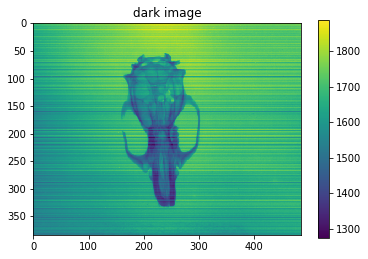

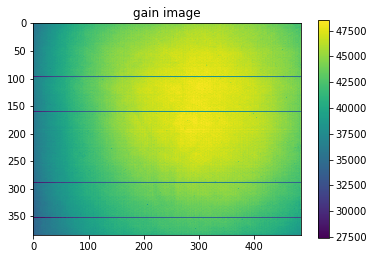

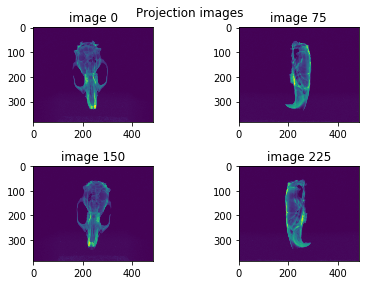

In [5]:
plt.figure()
plt.imshow(np.rot90(offset_image))
plt.title('dark image')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.rot90(gain_image))
plt.title('gain image')
plt.colorbar()
plt.show()

# Display a sample
plt.figure()
plt.subplot(221)
plt.imshow(np.rot90(proj_data[0]))
plt.title('image 0')

plt.subplot(222)
plt.imshow(np.rot90(proj_data[75]))
plt.title('image 75')

plt.subplot(223)
plt.imshow(np.rot90(proj_data[150]))
plt.title('image 150')

plt.subplot(224)
plt.imshow(np.rot90(proj_data[225]))
plt.title('image 225')

plt.tight_layout()
plt.suptitle('Projection images')
plt.show()


## Perform a simple FBP reconstruction

For the reconstruction we set some parameters as read from the various metadata files:

In [6]:
# Object
sample_size = 15  # (only x-y radius) [mm]

# Geometry
sdd = 281.000000  # [mm]
sod = 154.999512  # [mm]
first_angle = 0.0  # [deg]
last_angle = 360.0  # [deg]

# Detector
det_px_size = 0.149600  # (binned) [mm]
det_shape = (972, 768)

# Reconstruction (not necessarily needed)
voxel_size = 0.082519  # = px_size / magnification  [mm]
horiz_center = 481.283422  # [px]
vert_center = 387.700535  # [px]

# Region of interest (on detector, rest has no object info)
xmin = 292.000000  # [px]
xmax = 660.000000  # [px]
ymin = 292.000000  # [px]
ymax = 660.000000  # [px]
zmin = 98.000000  # [px]
zmax = 686.000000  # [px]


With these values we define the ODL geometry:

In [7]:
angle_partition = odl.uniform_partition(
    np.radians(first_angle), np.radians(last_angle), num_projs_subset)

det_min_pt = -det_px_size * np.array(det_shape) / 2.0
det_max_pt = det_px_size * np.array(det_shape) / 2.0
det_partition = odl.uniform_partition(det_min_pt, det_max_pt, det_shape_subset)

src_radius = sod
det_radius = sdd - sod
magnification = (src_radius + det_radius) / src_radius

# Account for shift between object center and rotation center
rot_center_x = (horiz_center - (xmax + xmin) / 2) * det_px_size / magnification
rot_center_z = (vert_center - (zmax + zmin) / 2) * det_px_size / magnification

# This currently works by a hack in ODL
geometry = odl.tomo.ConeFlatGeometry(
    angle_partition, det_partition, src_radius, det_radius,
    rot_center=-np.array([rot_center_x, 0, rot_center_z]))

print(geometry)

ConeFlatGeometry(
    uniform_partition(0.0, 6.283, 300),
    uniform_partition([-72.7056, -57.4464], [ 72.7056,  57.4464], (486, 384)),
    src_radius=154.999512,
    det_radius=126.00048799999999
)


Now we define a reconstruction space that matches the resolution of the detector (including the magnification effect):

In [8]:
# Volume size in mm
vol_size = np.array([xmax - xmin, ymax - ymin, zmax - zmin])
vol_size *= det_px_size / magnification
vol_size *= 1.1  # safety margin

vol_shift = np.array([rot_center_x, 0, rot_center_z])
vol_min_pt = -vol_size / 2 + vol_shift
vol_max_pt = vol_size / 2 + vol_shift
vol_shape = (vol_size / min(det_partition.cell_sides) * magnification).astype(int)
vol_shape = (np.ceil(vol_shape / 32) * 32).astype(int)  # next multiple of 32

reco_space = odl.uniform_discr(vol_min_pt, vol_min_pt + vol_size, vol_shape,
                               dtype='float32')
print('Reconstruction space:\n', reco_space)

Reconstruction space:
 uniform_discr([-16.2659, -16.7019, -27.0415], [ 17.1379,  16.7019,  26.332 ], (224, 224, 352), dtype='float32')


We perform a simple FBP reconstruction and plot 3 "interesting" orthoslices:

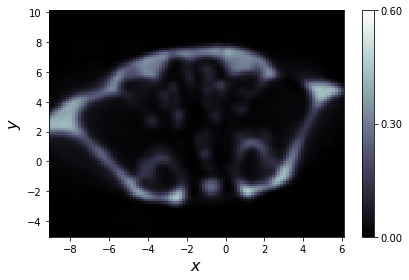

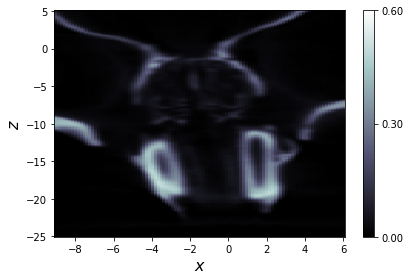

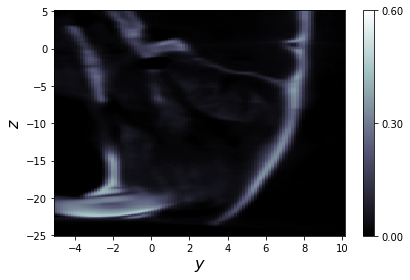

In [9]:
full_ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
full_fbp_op = odl.tomo.fbp_op(full_ray_trafo, padding=False,
                              filter_type='Hamming', frequency_scaling=0.99)
full_fbp_reco = full_fbp_op(proj_data)

# Display window (min/max coordinate)
x_window = (-9, 6)
y_window = (-5, 10)
z_window = (-25, 5)

_ = full_fbp_reco.show(coords=[x_window, y_window, np.mean(z_window)], clim=[0, 0.6])
_ = full_fbp_reco.show(coords=[x_window, np.mean(y_window), z_window], clim=[0, 0.6])
_ = full_fbp_reco.show(coords=[np.mean(x_window), y_window, z_window], clim=[0, 0.6])

To assess the feasibility of iterative reconstruction, let us look at the evaluation times of the forward operator and the adjoint:

In [10]:
%timeit full_ray_trafo(full_ray_trafo.domain.zero())

2.22 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit full_ray_trafo.adjoint(full_ray_trafo.range.zero())

621 ms ± 7.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Two-resolution reconstruction

To enable iterative reconstruction for this problem, we reduce the problem size by using two different resolutions: full resolution in the region of interest (ROI) and significantly lower resolution in the rest.

Mathematically, we write a function $x$ as the sum of two functions $x = x_1 + x_2$, where $x_2$ represents the region of interest and $x_1$ the rest (coarsely discretized later on).

Hence, with our forward operator $R$, the cone-beam ray transform, we get two contributions to the data,

$$
    y = R\big(M(x_1)\big) + R(x_2).
$$

Here, $M$ masks the ROI to not count it twice in the forward projection.

We can now see $x_1$ and $x_2$ as two independent variables and perform variational reconstruction with different regularization in the different parts of the volume. In the example below, we solve

$$
    x^* = (x_1^*, x_2^*) = \text{argmin}_{x_1, x_2} \left[ \|A(x_1, x_2) - y\|_2^2 + \alpha_1 \|\nabla x_1\|_2^2 + \text{TV}(x_2) \right],
$$

i.e., we use TV regularization in the ROI and a smoothness prior (unimportant) outside.

We create a smaller space that only contains the ROI:

In [12]:
# Take full resolution in the ROI
roi_min_pt = np.array([-9.0, -5.0, -25.0])
roi_max_pt = np.array([6.0, 10.0, 5.0])
roi_shape = np.ceil((roi_max_pt - roi_min_pt) / reco_space.cell_sides).astype(int)
print('ROI shape:', roi_shape)
X2 = odl.uniform_discr(roi_min_pt, roi_max_pt, roi_shape,
                       dtype=reco_space.dtype)

# Take 16 times coarser discretization outside
outer_shape = np.ceil(np.divide(reco_space.shape, 16)).astype(int)
print('Outer shape:', outer_shape)
X1 = odl.uniform_discr(reco_space.min_pt, reco_space.max_pt, outer_shape,
                       dtype=reco_space.dtype)
y = proj_data

ROI shape: [101 101 198]
Outer shape: [14 14 22]


Now we create the operators and functionals for the problem formulation. For the data match, we have the forward operator

$$
    A: X_1 \times X_2 \to Y, \quad A(x_1, x_2) = R_1\big(M(x_1)\big) + R_2(x_2)
$$

and the squared $L^2$ data fit, resulting in the total data matching functional

$$
    \|A(x_1, x_2) - y\|_2^2.
$$

Next, we generate a gradient operator

$$
    G_1 = \nabla: X_1 \to X_1^3
$$

on $X_1$ and the squared $L^2$ norm on its range, to get the smooth regularizer $\|\nabla x_1\|_2^2$.

For the TV term, we use the gradient on $X_2$,

$$
    G_2 = \nabla: X_2: \to X_2^3,
$$

to define the TV functional $TV(x_2) = \|x_2\|_1$.

We put together all the pieces:

In [13]:
# Functionals
# D = data matching functional: Y -> R, ||. - g||_Y^2
# S1 = (alpha1 * squared L2-norm): X1^3 -> R, for Tikhonov functional
# S2 = (alpha2 * L12-Norm): X2^3 -> R, for isotropic TV

# Operators
# A = broadcasting forward operator: X1 x X2 -> Y
# G1 = spatial gradient: X1 -> X1^2
# G2 = spatial gradient: X2 -> X2^2
# B1 = G1 extended to X1 x X2, B1(f1, f2) = G1(f1)
# B2 = G2 extended to X1 x X2, B2(f1, f2) = G2(f2)

R1 = odl.tomo.RayTransform(X1, geometry)
R2 = odl.tomo.RayTransform(X2, geometry)
M = odl_multigrid.MaskingOperator(X1, roi_min_pt, roi_max_pt)

A1 = R1 * M
A2 = R2
A = odl.ReductionOperator(A1, A2)

G1 = odl.Gradient(X1, pad_mode='symmetric')
G2 = odl.Gradient(X2, pad_mode='order1')

alpha1 = 1e0
alpha2 = 5e-2
S1 = alpha1 * odl.solvers.L2NormSquared(G1.range)
S2 = alpha2 * odl.solvers.GroupL1Norm(G2.range)

B1 = G1 * odl.ComponentProjection(X1 * X2, 0)
B2 = G2 * odl.ComponentProjection(X1 * X2, 1)

D = odl.solvers.L2NormSquared(A.range).translated(y)

We check how much we gained regarding runtimes:

In [14]:
%timeit A(A.domain.zero())

1.34 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit A.adjoint(A.range.zero())

255 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The forward operator is not so much faster, since we still have the same number of rays to compute, i.e., forward projection scales with the number of angles and detector pixels. That is something to improve later.

However, the adjoint is much faster since it scales with the number voxels.

Now we do the usual steps and reconstruct:

In [16]:
# Arguments for the solver
f = odl.solvers.ZeroFunctional(A.domain)  # unused
g = [D, S1, S2]
L = [A, B1, B2]

# Operator norm estimation for the step size parameters
xstart = odl.phantom.white_noise(A.domain)
A_norm = odl.power_method_opnorm(A, maxiter=10)
B1_norm = odl.power_method_opnorm(B1, xstart=xstart, maxiter=10)
B2_norm = odl.power_method_opnorm(B2, xstart=xstart, maxiter=10)

print('||A||', A_norm)
print('||B1||', B1_norm)
print('||B2||', B2_norm)

||A|| 25.6046416844
||B1|| 1.30502769395
||B2|| 21.3440004275


In [17]:
# We need tau * sum[i](sigma_i * opnorm_i^2) < 4 for convergence, so we
# choose tau and set sigma_i = c / (tau * opnorm_i^2) such that sum[i](c) < 4
tau = 1.0
opnorms = [A_norm, B1_norm, B2_norm]
sigmas = [3.0 / (tau * len(opnorms) * opnorm ** 2) for opnorm in opnorms]

callback = odl.solvers.CallbackPrintIteration(step=20)

x = A.domain.zero()
odl.solvers.douglas_rachford_pd(
    x, f, g, L, tau, sigmas, niter=200, callback=callback)

x1, x2 = x

iter = 0
iter = 20
iter = 40
iter = 60
iter = 80
iter = 100
iter = 120
iter = 140
iter = 160
iter = 180


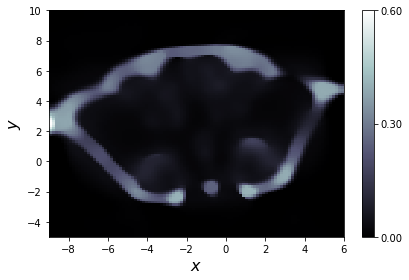

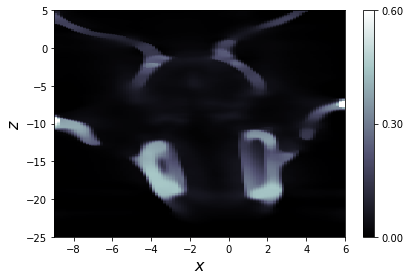

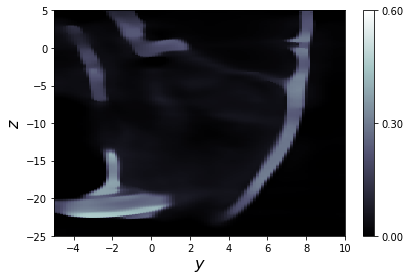

In [18]:
_ = x2.show(coords=[None, None, np.mean(z_window)], clim=[0, 0.6])
_ = x2.show(coords=[None, np.mean(y_window), None], clim=[0, 0.6])
_ = x2.show(coords=[np.mean(x_window), None, None], clim=[0, 0.6])